In [1]:
%matplotlib inline
import sys
import os
import pathlib
import math
import numpy as np
import pandas
import psycopg2
import psycopg2.extras
import matplotlib
from matplotlib import pyplot
from mosthosts_desi import MostHostsDesi

In [2]:
# Read the salt2 fits from the lightcurve database
dbname = 'curveball'
dbhost = 'decatdb.lbl.gov'
dbport = 5432
dbuser = 'curveball'
try:
    sfile = pathlib.Path( os.getenv("HOME") )/ "secrets" / "curveball_dbpasswd.txt"
    with open(sfile) as ifp:
        dbpasswd = ifp.readline().strip()
except Exception as e:
    dbpasswd = input( "database password: ")
    dbpasswd = dbpasswd.strip()

db = psycopg2.connect( host=dbhost, port=dbport, dbname=dbname, user=dbuser, password=dbpasswd,
                       cursor_factory=psycopg2.extras.RealDictCursor )
cursor = db.cursor()
q = ( "SELECT o.name,f.z,f.mbstar,f.dmbstar,f.x0,f.dx0,f.x1,f.dx1,f.c,f.dc,f.primary_fit "
      "FROM salt2fit f "
      "INNER JOIN object o ON o.id=f.object_id "
      "WHERE f.donotuse=FALSE" )
cursor.execute(q)
saltfits = pandas.DataFrame( cursor.fetchall() )

# For those objects that have a primary fit marked, keep that fit.  Otherwise, randomly keep the first fit
primaries = set( saltfits[ saltfits.primary_fit ].name.values )
saltfits.drop( saltfits[ saltfits.name.isin(primaries) & (~saltfits.primary_fit) ].index, inplace=True )
saltfits = saltfits.groupby( 'name' ).first().reset_index()

In [3]:
# Look for some messes
bad = saltfits[ ( saltfits.mbstar.values > 23) | ( saltfits.mbstar.values < 14 ) | ( ~np.isfinite( saltfits.mbstar.values ) ) ]
print( f'{len(bad)} bad values\n{bad[["name","z","mbstar","dmbstar"]]}\n' )
saltfits = saltfits[ saltfits.name.apply( lambda r: r not in bad.name.values ) ]

# Throw out extreme colors
colorful = saltfits[ ( saltfits.c < -1 ) | ( saltfits.c > 1 ) ]
print( f'{len(colorful)} extreme colors\n{colorful[ ["name","z","mbstar","c"] ]}' )
saltfits = saltfits[ saltfits.name.apply( lambda r: r not in colorful.name.values ) ]

3 bad values
            name       z     mbstar   dmbstar
1   ZTF18aajivpr  0.0515        inf -0.533639
42  ZTF19abaukyt  0.0716        inf -0.096449
79  ZTF20abeeyrs  0.0973  11.534117  1.159573

5 extreme colors
            name       z     mbstar         c
0   ZTF18aaermez  0.0227  19.046319  1.067068
21  ZTF19aaafica  0.0230  19.626083  1.111509
28  ZTF19aaqtcmy  0.0638  21.193136  1.772883
76  ZTF20aayjxdv  0.0619  18.055053 -1.643741
84  ZTF20abixkhh  0.0446  20.386788  1.711217


In [4]:
# Read in the MostHosts DESI info
subset = "fuji"
mhd = MostHostsDesi( release=subset, force_regen=False )

[2022-06-21 11:33:18,044 - INFO] - Loading mosthosts table...
[2022-06-21 11:33:19,133 - INFO] - ...mosthosts table loaded.
[2022-06-21 11:33:19,154 - INFO] - Read dataframes from pkl files


In [8]:
mhd.df.index.values

array([('09a', 1), ('09aa', 1), ('09ab', 1), ..., ('unknown-97', 2),
       ('unknown-98', 1), ('unknown-99', 1)], dtype=object)

In [9]:
zs = []
mbstars = []
dmbstars = []
mbcors = []
dmbcors = []
# overlap = mhd.df[ [ i in saltfits.name.values for i in mhd.df['snname'].values ] ]
overlap = mhd.df.xs( saltfits.name.values, level=1 )

overlap

TypeError: '['ZTF18aanygjk' 'ZTF18aarwxum' 'ZTF18aaunfqq' 'ZTF18aaxdrjn'
 'ZTF18aaydmkh' 'ZTF18aayjvve' 'ZTF18abcsgvj' 'ZTF18abfgygp'
 'ZTF18abjvhec' 'ZTF18abjwahi' 'ZTF18ablongw' 'ZTF18ablqlzp'
 'ZTF18abmjvpb' 'ZTF18abmkaps' 'ZTF18abmmdif' 'ZTF18abmxfrc'
 'ZTF18abobkii' 'ZTF18aceyjco' 'ZTF18acqsztr' 'ZTF19aajwhbc'
 'ZTF19aammewd' 'ZTF19aanmdsr' 'ZTF19aanmeyw' 'ZTF19aanuhox'
 'ZTF19aanxgrz' 'ZTF19aarfnto' 'ZTF19aarprog' 'ZTF19aatgwhs'
 'ZTF19aathcvn' 'ZTF19aauvjws' 'ZTF19aavmgtv' 'ZTF19aawhniz'
 'ZTF19aawqckx' 'ZTF19aayslow' 'ZTF19aaziick' 'ZTF19aazlsfj'
 'ZTF19aazxcvl' 'ZTF19abakdjd' 'ZTF19abbvzgr' 'ZTF19abetjcx'
 'ZTF19abfdsbu' 'ZTF19abgppki' 'ZTF19abhzewi' 'ZTF19abitbcj'
 'ZTF19abmzord' 'ZTF19abnmrqt' 'ZTF19abpbqor' 'ZTF19abqhikf'
 'ZTF19abxdnhr' 'ZTF19abzkexb' 'ZTF19acfrntd' 'ZTF19acordoi'
 'ZTF19acqehbt' 'ZTF20aaaxacu' 'ZTF20aafcjln' 'ZTF20aaghlkv'
 'ZTF20aaideho' 'ZTF20aakodiq' 'ZTF20aammhli' 'ZTF20aammicx'
 'ZTF20aamttni' 'ZTF20aansktb' 'ZTF20aappghn' 'ZTF20aatzwgk'
 'ZTF20aauonld' 'ZTF20aaurhio' 'ZTF20aauuiri' 'ZTF20aauwhyi'
 'ZTF20aavnnat' 'ZTF20aavrloz' 'ZTF20aaxicpu' 'ZTF20aazhzna'
 'ZTF20abawntz' 'ZTF20abegate' 'ZTF20abfsemq' 'ZTF20abguygh'
 'ZTF20abhmnom' 'ZTF20abpuijn' 'ZTF20abqefja' 'ZTF20abxgwjr'
 'ZTF20abyfgri' 'ZTF20abyskia']' is an invalid key

In [ ]:
# From a fit I ran...
α = 0.151
β = 1.559
scriptm = 24.135

with open( "z_mbstar_saltparam.dat", "w") as ofp:
    ofp.write( f'#{"z":>6s}   mbstar  dmbstar   '
               f'{"x0":>12s} {"dx0":>12s}   '
               f'{"x1":>8s} {"dx1":>8s}   '
               f'{"c":>7s} {"dc":>7s}  sn\n' )
    for i, row in saltfits.iterrows():
        overlap = mhd.df[ mhd.df['snname'].values == row['name'] ].copy()
        if len(overlap) == 0:
            sys.stderr.write( f'No overlap for {row["name"]}\n' )
        elif len(overlap) > 1:
            sys.stderr.write( f'{len(overlap)} overlaps for {row["name"]}, picking one with closest z to sn z\n' )
            overlap['absdz'] = np.fabs( overlap['z'].values - row['z'] )
            overlap = overlap.loc[ overlap['absdz'].idxmin() ]
        else:
            overlap = overlap.iloc[0]
        zs.append( overlap['z'] )
        mbstars.append( row['mbstar'] )
        dmbstars.append( row['dmbstar'] )

        mbcor = row['mbstar'] + α * row['x1'] - β * row['c']
        dmbcor = math.sqrt( row['dmbstar']**2 + ( α * row['dx1'] )**2 + ( β * row['dc'] )**2 )
        mbcors.append( mbcor )
        dmbcors.append( dmbcor )

        ofp.write( f'{overlap["z"]:7.4f}   '
                   f'{row["mbstar"]:7.4f} {row["dmbstar"]:7.4f}   '
                   f'{row["x0"]:12.4e} {row["dx0"]:12.4e}   '
                   f'{row["x1"]:8.4f} {row["dx1"]:8.4f}   '
                   f'{row["c"]:7.4f} {row["dc"]:7.4f} {row["name"]}\n' )

saltfits['mbcor'] = mbcors
saltfits['dmbcor'] = dmbcors

Plotting 82 points


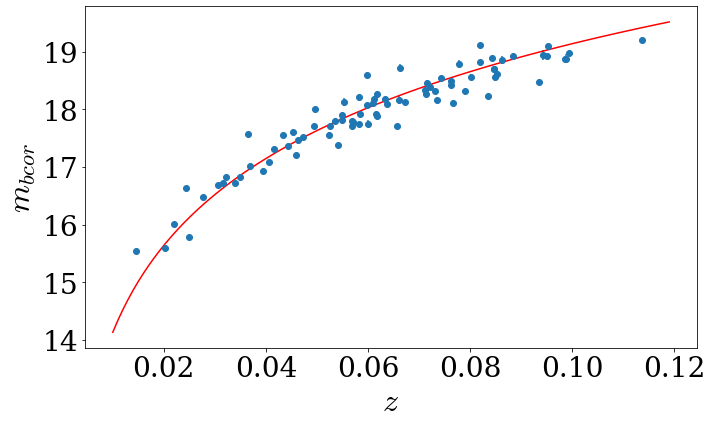

In [7]:
print( f"Plotting {len(zs)} points" )

matplotlib.rcParams.update( { 'mathtext.fontset': 'cm',
                              'font.family': 'serif' } )

fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot(1, 1, 1)

ax.errorbar( zs, mbcors, dmbcors, linestyle='None', marker='o' )
ax.set_xlabel( "$z$", fontsize=32, fontdict = { 'family': 'serif' } )
ax.set_ylabel( "$m_{bcor}$", fontsize=32, fontfamily='serif' ) #  with α={α} and β={β}", fontsize=18 )
ax.tick_params( axis='both', labelsize=28 )

# A fit I ran...

zfit = np.arange( 0.01, 0.12, 0.001 )
mbcorfit = scriptm + 5 * np.log10( zfit )
ax.plot( zfit, mbcorfit, marker=None, color='red' )

fig.show()
fig.savefig( "it.svg" )